### Evaluation

En este cuaderno se presentan las métricas de evaluación utilizadas para valorar la calidad de las imágenes generadas por el modelo. Asimismo, se analiza el rendimiento del modelo durante el entrenamiento en función del número de épocas. Este análisis nos permitirá identificar el número óptimo de épocas como hiperparámetro.

Luego se va a evaluar el efecto de distintas tasas de aprendizaje sobre  la perdida del modelo.

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional

from noise_schedules import LinearSchedule, CosineSchedule
from torchvision import transforms
from utils.data_loader import load_dataset

from utils import (
    plot_image_grid,
    load_dataset,
    plot_image_evolution_color,
    sample_initial_latents,
)

from samplers import euler_maruyama_integrator, predictor_corrector_integrator
from diffusion import VPProcess, VEProcess, SubVPProcess
import time
from score_models import ScoreNet32
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.notebook import trange
from tqdm import tqdm
from evaluation import compute_fid, compute_bpd, compute_inception_score

n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))

device ='cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of threads: 12


In [4]:
def colorize_grayscale(tensor_img):
    if tensor_img.shape[0] == 1:
        r, g, b = [torch.rand(1).item() for _ in range(3)]
        return torch.cat([tensor_img * r, tensor_img * g, tensor_img * b], dim=0)
    return tensor_img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(colorize_grayscale),
])

data= load_dataset("cifar10", transform=transform, return_loader=False)

In [5]:
target_class = 1
indices_class_1 = torch.where(torch.tensor(data.targets) == target_class)[0]
data_class_1 = Subset(data, indices_class_1)

In [6]:
from torch.utils.data import random_split

# 6000 imágenes del dígito 3
n_total = len(data_class_1)
n_train = int(0.8 * n_total)
n_test = n_total - n_train

data_train_split, data_test = random_split(data_class_1, [n_train, n_test])


In [7]:
len(data_train_split), len(data_test)

(4000, 1000)

In [8]:
sigma = 25.0
diffusion_process = VEProcess(
    sigma=sigma
)
# Dataloader
batch_size = 32
data_loader_train = DataLoader(
    data_train_split,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)


data_loader = DataLoader(
    data_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

In [ ]:
# Crear carpeta de checkpoints si no existe
os.makedirs("checkpoints", exist_ok=True)

# Instanciar el modelo
score_model = torch.nn.DataParallel(
    ScoreNet32(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)
).to(device)

# Hiperparámetros
learning_rate = 1e-3
n_epochs = 500
milestones = [5, 10, 30, 50, 100, 200, 500]
optimizer = Adam(score_model.parameters(), lr=learning_rate)


# Registro de resultados
training_log = {}

# Entrenamiento
tqdm_epoch = trange(n_epochs)
start_time = time.time()

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader_train:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    epoch_loss = avg_loss / num_items
    tqdm_epoch.set_description(f"Epoch {epoch+1} | Loss: {epoch_loss:.6f}")

    # Guardar checkpoint en épocas clave
    if (epoch + 1) in milestones:
        checkpoint_path = f"checkpoints/checkpoint_epoch_{epoch+1}.pth"
        torch.save(score_model.state_dict(), checkpoint_path)

        elapsed = time.time() - start_time
        training_log[epoch + 1] = {
            "loss": epoch_loss,
            "time_sec": elapsed,
            "checkpoint": checkpoint_path
        }

import json
with open("checkpoints/training_log.json", "w") as f:
    json.dump(training_log, f, indent=4)


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
import json

# Parámetros globales
T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
diffusion_coefficient = diffusion_process.diffusion_coefficient
n_images = 40
n_steps = 1000

# Cargar log de entrenamiento
with open("checkpoints/training_log.json", "r") as f:
    training_log = json.load(f)

# Lista para guardar resultados por época
evaluation_results = []

# Evaluar cada checkpoint
for epoch_str, info in training_log.items():
    epoch = int(epoch_str)
    checkpoint_path = info["checkpoint"]

    # Instanciar y cargar modelo
    checkpoint = torch.load(checkpoint_path, map_location=device)
    score_model.load_state_dict(checkpoint)
    score_model.eval()

    # Generar imágenes desde ruido
    image_T = torch.randn(n_images, 3, 32, 32).to(device)

    with torch.no_grad():
        times, synthetic_images_t = euler_maruyama_integrator(
            x_0=image_T,
            t_0=T,
            t_end=1e-3,
            n_steps=n_steps,
            drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
            diffusion_coefficient=diffusion_coefficient,
            seed=42
        )

    generated_images = synthetic_images_t[..., -1]

    # Normalizar imágenes a [0, 1]
    generated_images = (generated_images - generated_images.min()) / (
        generated_images.max() - generated_images.min() + 1e-8
    )

    # Obtener imágenes reales
    real_images, _ = next(iter(data_loader))
    real_images = real_images.to(device)[:n_images]

    # Calcular métricas
    fid = compute_fid(real_images, generated_images)
    bpd = compute_bpd(real_images, score_model, diffusion_process)
    is_mean, is_std = compute_inception_score(generated_images)


    # Guardar resultados en la lista
    evaluation_results.append({
        "epoch": epoch,
        "fid": float(fid),
        "bpd": float(bpd),
        "inception_score_mean": float(is_mean),
        "inception_score_std": float(is_std)
    })

# Guardar resultados en JSON
with open("evaluation_metrics.json", "w") as f:
    json.dump(evaluation_results, f, indent=4)

In [15]:
import pandas as pd

# Cargar training_log
with open("checkpoints/training_log.json", "r") as f:
    training_log = json.load(f)

# Cargar evaluation_metrics
with open("evaluation_metrics.json", "r") as f:
    evaluation_metrics = json.load(f)

# Combinar la información en una lista de dicts
rows = []

for eval_entry in evaluation_metrics:
    epoch = str(eval_entry["epoch"])
    train_info = training_log.get(epoch, {})
    
    row = {
        "Épocas": int(epoch),
        "Pérdida Final": train_info.get("loss", None),
        "Tiempo (s)": train_info.get("time_sec", None),
        "FID": eval_entry["fid"],
        "BPD": eval_entry["bpd"],
        "IS (media)": eval_entry["inception_score_mean"],
        "IS (std)": eval_entry["inception_score_std"],
    }
    rows.append(row)

# Crear DataFrame ordenado
df_results = pd.DataFrame(rows)
df_results = df_results.sort_values("Épocas").reset_index(drop=True)

In [16]:
df_results 

,Épocas,Pérdida Final,Tiempo (s),FID,BPD,IS (media),IS (std)
0,5,149.778394,10.569808,436.836077,3.053057,1.133100,0.048072
1,10,111.411002,20.419926,432.654482,3.938154,1.110654,0.037933
2,30,82.035701,60.481865,367.443580,2.058396,1.120142,0.033753
3,50,76.646466,100.920124,343.914472,1.881854,1.183916,0.056158
4,100,69.196890,203.050985,322.179481,1.807210,1.249127,0.063932
5,200,61.711060,404.950929,286.233837,1.552735,1.371910,0.111152
6,500,58.871097,1008.203147,288.543466,1.473130,1.400122,0.109874


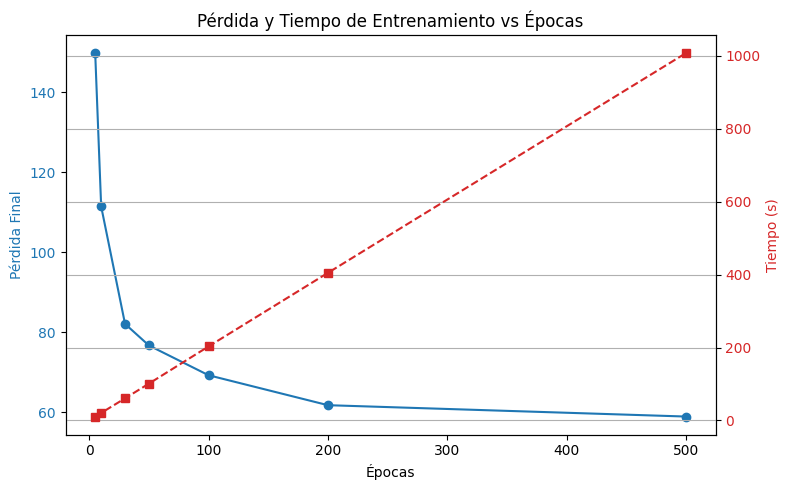

In [13]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

# Eje X: número de épocas
epochs = df_results["Épocas"]

# Eje Y1: pérdida final
color1 = "tab:blue"
ax1.set_xlabel("Épocas")
ax1.set_ylabel("Pérdida Final", color=color1)
ax1.plot(epochs, df_results["Pérdida Final"], marker="o", color=color1, label="Pérdida Final")
ax1.tick_params(axis='y', labelcolor=color1)

# Eje Y2: tiempo en segundos
ax2 = ax1.twinx()
color2 = "tab:red"
ax2.set_ylabel("Tiempo (s)", color=color2)
ax2.plot(epochs, df_results["Tiempo (s)"], marker="s", linestyle="--", color=color2, label="Tiempo")
ax2.tick_params(axis='y', labelcolor=color2)

# Título y formato
plt.title("Pérdida y Tiempo de Entrenamiento vs Épocas")
fig.tight_layout()
plt.grid(True)
plt.show()


In [9]:
# Configuración
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
n_epochs = 30
n_images = 50
n_steps = 1000
batch_size = 32

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
diffusion_coefficient = diffusion_process.diffusion_coefficient

results = []

for lr in learning_rates:

    score_model = torch.nn.DataParallel(
        ScoreNet32(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)
    ).to(device)
    
    optimizer = Adam(score_model.parameters(), lr=lr)

    # Entrenamiento
    start_time = time.time()
    for epoch in tqdm(range(n_epochs), desc=f"LR {lr}"):
        avg_loss = 0.0
        num_items = 0
        for x, y in data_loader_train:
            x = x.to(device)
            loss = diffusion_process.loss_function(score_model, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.size(0)
            num_items += x.size(0)
    elapsed = time.time() - start_time
    final_loss = avg_loss / num_items

    # Guardar checkpoint
    checkpoint_path = f"checkpoints/checkpoint_lr_{lr:.0e}.pth"
    torch.save(score_model.state_dict(), checkpoint_path)

    # Sampling
    score_model.eval()
    image_T = torch.randn(n_images, 3, 32, 32).to(device)
    with torch.no_grad():
        _, synthetic_images_t = euler_maruyama_integrator(
            x_0=image_T,
            t_0=T,
            t_end=1e-3,
            n_steps=n_steps,
            drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
            diffusion_coefficient=diffusion_coefficient,
            seed=42
        )
    generated_images = synthetic_images_t[..., -1]
    generated_images = (generated_images - generated_images.min()) / (
        generated_images.max() - generated_images.min() + 1e-8
    )

    # Imágenes reales
    real_images, _ = next(iter(data_loader))
    real_images = real_images.to(device)[:n_images]

    # Evaluación
    fid = compute_fid(real_images, generated_images)

    # Guardar resultado
    results.append({
        "Learning Rate": lr,
        "Pérdida Final": final_loss,
        "Tiempo (s)": elapsed,
        "FID": float(fid),
    })

LR 0.01: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


In [11]:
import pandas as pd
# Convertir a DataFrame
df_results_lr = pd.DataFrame(results)

In [12]:
df_results_lr 

,Learning Rate,Pérdida Final,Tiempo (s),FID
0,0.0001,133.584753,61.137979,432.820914
1,0.0005,91.929716,62.416464,396.252053
2,0.0010,88.334535,62.684322,382.341795
3,0.0050,80.207715,62.490019,342.724014
4,0.0100,82.027970,62.490259,355.502043


In [ ]:
checkpoint_path = "checkpoints/checkpoint_epoch_500.pth"
score_model = torch.nn.DataParallel(
    ScoreNet32(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)
).to(device)
score_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Parámetros de sampling
n_images = 10
T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
diffusion_coefficient = diffusion_process.diffusion_coefficient

# Imagen inicial: ruido
image_T = torch.randn(n_images, 3, 32, 32).to(device)  

# Sampling
with torch.no_grad():
    times, generated_images_t = predictor_corrector_integrator(
        x_0=image_T,
        t_0=T,
        t_end=1e-3,
        n_steps=3000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.001
    )

In [ ]:
_ = plot_image_evolution_color(
    images=generated_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 2000, 2500, 2800, 3000],
    figsize=(10, 10),
)